In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyPI as pi
import cv2

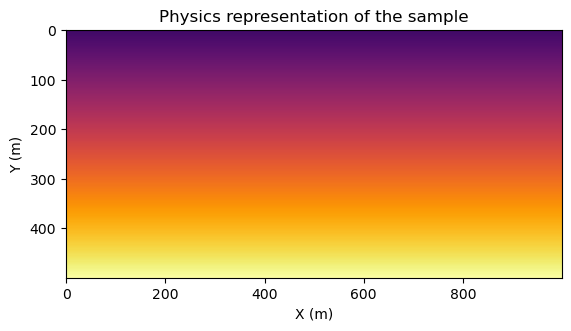

In [2]:
sample, sample_image, X, Y = pi.initialize_environment()
# Definir posiciones fijas para las líneas horizontales (en píxeles)
'''
fixed_positions = [100, 250, 400]  # Posiciones en el eje y

# Definir matrices específicas para cada línea en sample
line_matrices = [
    pi.jones_matrix(np.pi, np.pi/2),        # Línea 1
    pi.jones_matrix(np.pi/3, 0),      # Línea 2
    pi.jones_matrix(np.pi/3, np.pi/2)       # Línea 3
]
'''
n  = 499
# Parámetros


# Crear las matrices con el segundo valor variando de 0 a π (0, π/8, π/6,...)
#angles = [0, np.pi/8, np.pi/6, np.pi/4, np.pi/3, np.pi/2, np.pi, 2*np.pi]
angles = np.linspace(0, 2 * np.pi, n)
line_matrices = [pi.jones_matrix(np.pi/3, angle) for angle in angles]
#fixed_positions = np.arange(10, 500, 500//n)  # Posiciones en incrementos regulares
fixed_positions = np.arange(1, 500, 1)  # Posiciones en incrementos regulares


sample = pi.add_lines(fixed_positions, line_matrices, sample_image, sample, grosor=1)

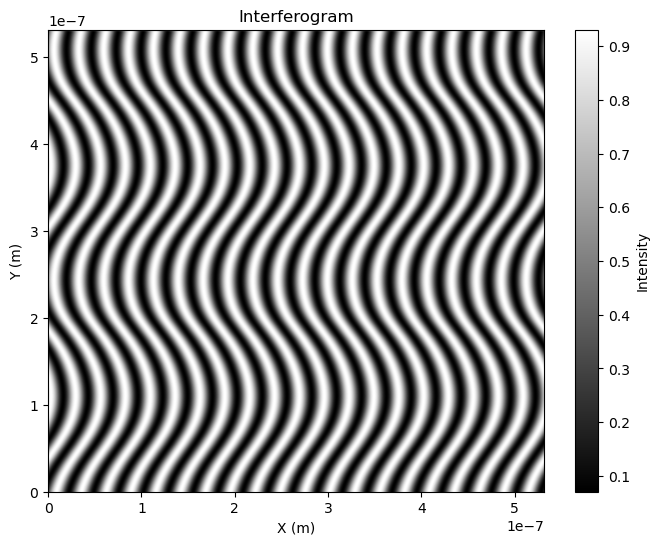

In [3]:
Eis = np.array([[1], [1j]])
Er = np.array([[1], [1j]])

I = pi.sample_intensity(Er, Eis, sample, X, Y)

In [4]:
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d

# Datos proporcionados
I1 = I[0]
I2 = I[20]

# Centrado de las señales (restar la media)
I1_centered = I1 - np.mean(I1)
I2_centered = I2 - np.mean(I2)

# Interpolación para aumentar la resolución
x_original = np.linspace(0, 1, len(I1))  # Eje en metros
x_interpolated = np.linspace(0, 1, 10 * len(I1))  # 10 veces más puntos

# Interpolación cúbica
interp_I1 = interp1d(x_original, I1_centered, kind='cubic')
interp_I2 = interp1d(x_original, I2_centered, kind='cubic')

# Nuevas señales interpoladas
I1_interp = interp_I1(x_interpolated)
I2_interp = interp_I2(x_interpolated)

# FFT para cada señal interpolada
fft_I1_interp = fft(I1_interp)
fft_I2_interp = fft(I2_interp)

# Determinar la frecuencia dominante
frequencies = fftfreq(len(x_interpolated), x_interpolated[1] - x_interpolated[0])
dominant_freq_index = np.argmax(np.abs(fft_I1_interp))

# Fases en la frecuencia dominante
phase_I1 = np.angle(fft_I1_interp[dominant_freq_index])
phase_I2 = np.angle(fft_I2_interp[dominant_freq_index])

# Desfase en radianes
delta_phi = phase_I2 - phase_I1

# Conversión del desfase a distancia (en metros)
wavelength = 1 / frequencies[dominant_freq_index]  # Longitud de onda
delta_x = delta_phi / (2 * np.pi) * wavelength     # Desfase convertido a metros

# Resultados
print(f"Fase de I1: {phase_I1:.3f} rad")
print(f"Fase de I2: {phase_I2:.3f} rad")
print(f"Desfase en radianes (Δφ): {delta_phi:.3f} rad")
print(f"Desfase en metros (Δx): {delta_x:.6e} m")


Fase de I1: -0.057 rad
Fase de I2: -1.516 rad
Desfase en radianes (Δφ): -1.459 rad
Desfase en metros (Δx): -1.161316e-02 m


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d

# Función para calcular el desfase utilizando FFT
def calcular_desfase(I1, I2, X):
    # Centrado de las señales (restar la media)
    I1_centered = I1 - np.mean(I1)
    I2_centered = I2 - np.mean(I2)
    
    # Interpolación para mejorar la resolución
    x_interpolated = np.linspace(X.min(), X.max(), 10 * len(X))
    interp_I1 = interp1d(X, I1_centered, kind='cubic')
    interp_I2 = interp1d(X, I2_centered, kind='cubic')

    # Señales interpoladas
    I1_interp = interp_I1(x_interpolated)
    I2_interp = interp_I2(x_interpolated)

    # FFT para cada señal interpolada
    fft_I1 = fft(I1_interp)
    fft_I2 = fft(I2_interp)

    # Determinar la frecuencia dominante
    frequencies = fftfreq(len(x_interpolated), x_interpolated[1] - x_interpolated[0])
    dominant_freq_index = np.argmax(np.abs(fft_I1))

    # Fases en la frecuencia dominante
    phase_I1 = np.angle(fft_I1[dominant_freq_index])
    phase_I2 = np.angle(fft_I2[dominant_freq_index])

    # Desfase calculado (en radianes)
    delta_phi = phase_I2 - phase_I1

    # Conversión del desfase a distancia (en metros)
    #wavelength = 1 / frequencies[dominant_freq_index]  # Longitud de onda
    wavelength = 532e-9
    delta_x = delta_phi / (2 * np.pi) * wavelength     # Desfase convertido a metros
    
    #return delta_x
    return delta_phi


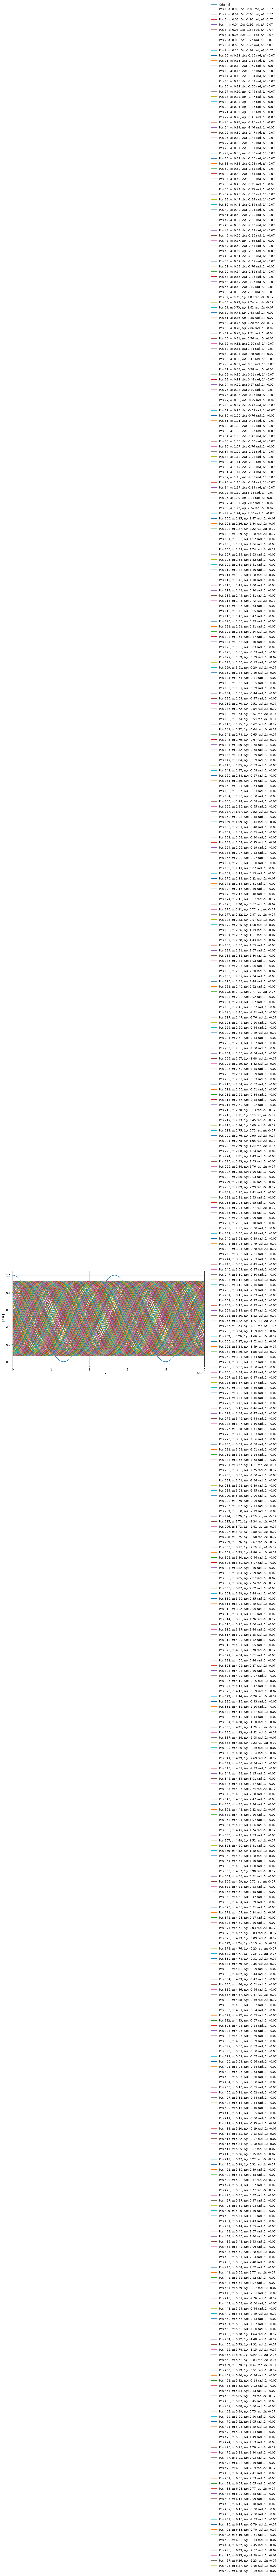

In [15]:
# Aumentar el tamaño de la figura para mejor visualización
plt.figure(figsize=(12, 6))

# Arreglos para almacenar desfases y cambios en la intensidad
desfases = []
cambios_intensidad = []

# Graficar la curva original
plt.plot(X[0], I[0], label="Original")

# Calcular el desfase y el cambio en la intensidad
for i, pos in enumerate(fixed_positions):
    # Cálculo del desfase con la nueva función
    desfase = calcular_desfase(I[0], I[pos], X[0])
    
    # Cálculo del cambio en la intensidad
    cambio_intensidad = np.max(I[pos]) - np.max(I[0])
    
    # Guardar en los arreglos
    desfases.append(desfase)
    cambios_intensidad.append(cambio_intensidad)
    
    # Graficar cada curva con la leyenda correspondiente
    plt.plot(X[0], I[pos], label=rf"Pos {pos}, $\alpha$: {angles[i % len(angles)]:.2f}, $\Delta\varphi$: {desfase:.2f} rad, $\Delta I$: {cambio_intensidad:.2f}")


plt.xlabel('X [m]')
plt.ylabel('I [a.u.]')
plt.xlim(0, 0.5e-7)

# Colocar la leyenda fuera del gráfico (a la derecha)
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.82))

plt.grid(True)
plt.show()

In [16]:
from scipy.ndimage import gaussian_filter1d  # Para suavizar la curva

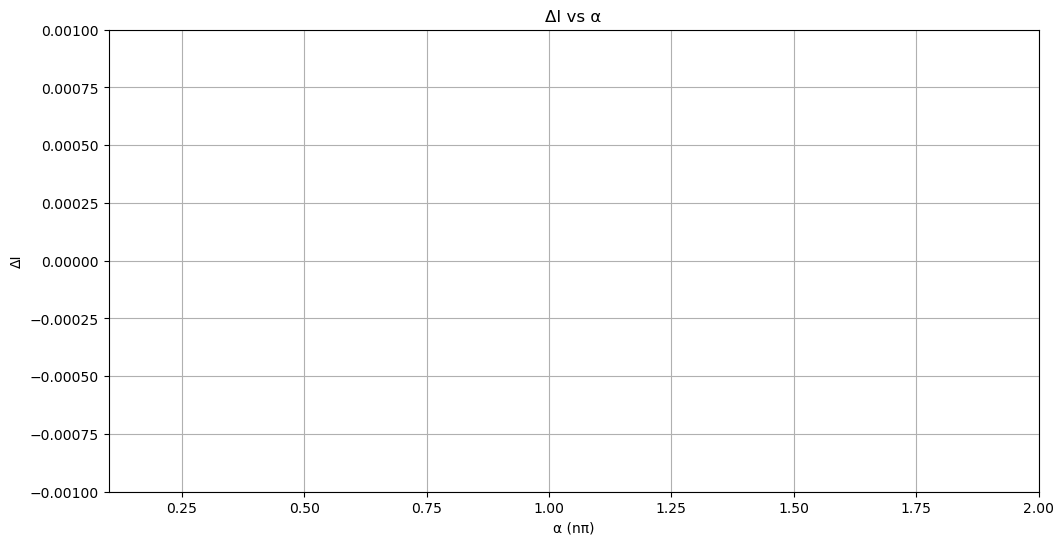

In [17]:
# Suavizar la curva usando una función Gaussiana
cambios_intensidad_suave = gaussian_filter1d(cambios_intensidad, sigma=0.01)

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(angles / np.pi, cambios_intensidad_suave, label='ΔI (suavizado)', color='b')
plt.xlabel('α (nπ)')
plt.ylabel('ΔI')
plt.xlim(0.1, 2)
plt.ylim(-0.001, 0.001)
plt.grid(True)
plt.title("ΔI vs α")
plt.show()

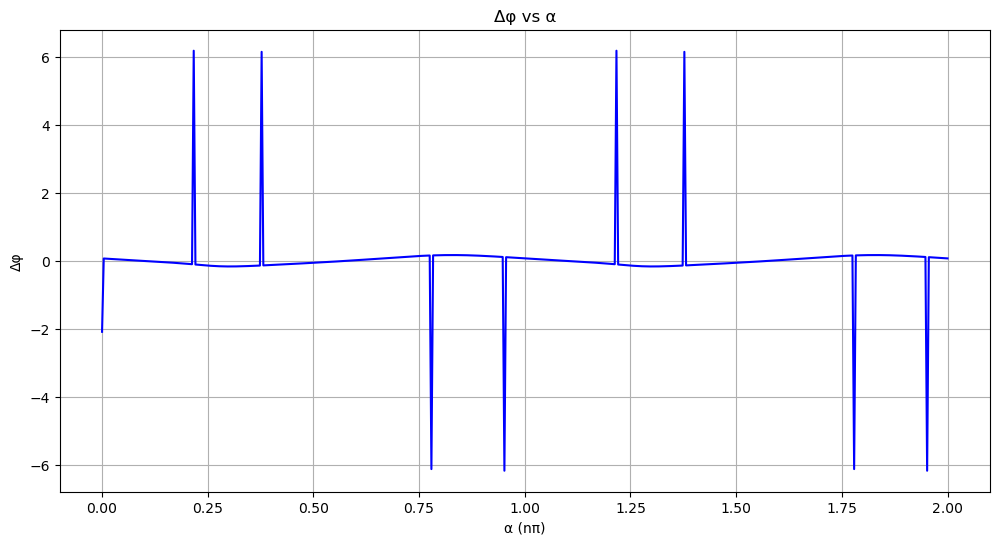

In [9]:
# Suavizar la curva usando una función Gaussiana
desfases_suavizado = gaussian_filter1d(desfases, sigma=0.01)

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(angles / np.pi, desfases_suavizado, label='Δφ (suavizado)', color='b')
plt.xlabel('α (nπ)')
plt.ylabel('Δφ')
plt.grid(True)
plt.title("Δφ vs α")
plt.show()